In [2]:
import tifffile
import pymeshlab
import numpy as np
from pathlib import Path

In [1]:
import sys
sys.path

['D:\\Tracking\\NucleiTracking\\tissue_cartography',
 'D:\\Tracking\\NucleiTracking',
 'C:\\Users\\Harrison\\.conda\\envs\\btc-test\\python311.zip',
 'C:\\Users\\Harrison\\.conda\\envs\\btc-test\\DLLs',
 'C:\\Users\\Harrison\\.conda\\envs\\btc-test\\Lib',
 'C:\\Users\\Harrison\\.conda\\envs\\btc-test',
 '',
 'C:\\Users\\Harrison\\.conda\\envs\\btc-test\\Lib\\site-packages',
 'd:\\tracking\\linajea\\src\\funlib-learn-torch',
 'd:\\tracking\\linajea\\src\\funlib-run',
 'd:\\tracking\\linajea\\src\\daisy',
 'd:\\tracking\\linajea\\src\\gunpowder',
 'd:\\tracking\\linajea',
 'C:\\Users\\Harrison\\.conda\\envs\\btc-test\\Lib\\site-packages\\win32',
 'C:\\Users\\Harrison\\.conda\\envs\\btc-test\\Lib\\site-packages\\win32\\lib',
 'C:\\Users\\Harrison\\.conda\\envs\\btc-test\\Lib\\site-packages\\Pythonwin']

In [5]:
base_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_03_18_trk\recon")
arr = tifffile.imread(base_path / "recon_fused_tp_262_ch_0.tif")

In [5]:
from skimage.filters import difference_of_gaussians
from skimage.feature import peak_local_max

dog = difference_of_gaussians(arr, 2, 6)
peaks = peak_local_max(dog, min_distance=5, threshold_abs=50)

In [6]:
import napari

viewer = napari.Viewer()

points = viewer.add_points(peaks, size=5)

napari.run()

In [3]:
import pymeshlab
from blender_tissue_cartography import interface_pymeshlab as intmsl
from blender_tissue_cartography import remesh_pymeshlab as tcremesh_pymeshlab

import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import transform
from scipy import ndimage
import os
import igl

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import mesh as tcmesh
from blender_tissue_cartography import remesh as tcremesh
from blender_tissue_cartography import interpolation as tcinterp
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import morphsnakes

In [9]:
point_cloud = tcmesh.ObjMesh(vertices=peaks, faces=[])
point_cloud_pymeshlab = intmsl.convert_to_pymeshlab(point_cloud)

In [10]:
ms = pymeshlab.MeshSet()
ms.add_mesh(point_cloud_pymeshlab)

ms.compute_normal_for_point_clouds(k=20, smoothiter=2)
ms.generate_surface_reconstruction_screened_poisson(depth=8, fulldepth=5,)

ms.meshing_isotropic_explicit_remeshing(iterations=10, targetlen=pymeshlab.PercentageValue(1))

mesh_reconstructed = intmsl.convert_from_pymeshlab(ms.current_mesh())

In [11]:
mesh_reconstructed.faces.shape

(17150, 3)

In [12]:
mesh_reconstructed.write_obj("test_dog_peaks.obj")

In [14]:
mesh_reconstructed = tcremesh_pymeshlab.reconstruct_poisson(peaks, samplenum=1000,
                                                            reconstruc_args={"depth": 8, "fulldepth": 5})
mesh_reconstructed.faces.shape

(8504, 3)

In [15]:
mesh_reconstructed.write_obj("test_dog_peaks2.obj")

In [50]:
mesh_uv = tcmesh.ObjMesh.read_obj(str(base_path / "mesh_with_UV.obj"))
normal_offsets = np.linspace(-5, 5, 11)
mapping_arr = tifffile.imread(base_path / "recon_fused_tp_80_ch_0.tif")

In [51]:
projected_data, projected_coordinates, projected_normals = tcinterp.create_cartographic_projections(
    image=np.expand_dims(mapping_arr, axis=0),
    mesh=mesh_uv,
    resolution=(1, 1, 1),
    normal_offsets=normal_offsets,
    uv_grid_steps=2048)
print("Image shape:", projected_data.shape)

Image shape: (1, 11, 2048, 2048)


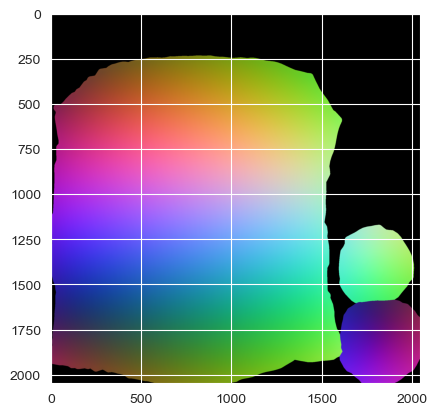

In [48]:
plt.imshow(np.nan_to_num(projected_coordinates) / np.max(np.max(np.nan_to_num(projected_coordinates), axis=0), axis=0))

In [52]:
maxp = np.array(np.max(projected_data[0], axis=0), dtype=np.float32)
maxp = np.clip((maxp - np.quantile(mapping_arr, 0.5)) / (np.max(mapping_arr - np.min(mapping_arr))), 0, 1)
maxp = np.array(np.rint(maxp * 255), dtype=np.uint8)
# plt.imshow(maxp, cmap="gray")
# plt.show()
tifffile.imwrite(base_path / "projected3.tif", maxp, imagej=True)

C:\Users\Harrison\AppData\Local\Temp\ipykernel_34744\4187275714.py:3: RuntimeWarning: invalid value encountered in cast
  maxp = np.array(np.rint(maxp * 255), dtype=np.uint8)


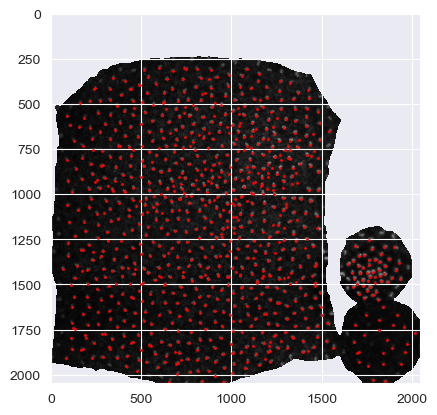

In [37]:
from skimage.filters import difference_of_gaussians
from skimage.feature import peak_local_max

dog = difference_of_gaussians(maxp, 4, 10)
peaks = peak_local_max(dog, min_distance=5, threshold_abs=15)

plt.imshow(maxp, cmap="gray")
plt.scatter(peaks[:, 1], peaks[:, 0], c="red", s=1)